In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pygmt
import rf
import obspy
from math import ceil

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize



In [3]:
try:
    dataroot = os.environ["DATADIR"]
except KeyError:
    dataroot = "rf_data/processed/"
try:
    run = os.environ['RUN']
except KeyError:
    print("Using latest run")
    run = max(
        [
            os.path.join(dataroot, d)
            for d in os.listdir(dataroot)
            if os.path.isdir(os.path.join(dataroot, d))
        ],
        key=os.path.getmtime,
    )
stream = rf.read_rf(os.path.join(run, "rfstream.h5"), format='h5')
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])

delays_df = pd.read_csv(os.path.join(run, "delays.txt"), names=("Network", "Station", "Longitude", "Latitude", "TPsb"), sep="\s+")
delays_df.set_index("Station", inplace=True)
delays_df.head()

Using latest run


Network   Longitude   Latitude  TPsb
Station                                     
BM31         OA  129.993058 -22.995938   0.0
BN29         OA  130.496421 -22.006397   0.0
BO24         OA  130.997155 -19.507225   0.0
BV23         OA  134.479800 -19.018600   0.0
BV30         OA  134.462000 -22.494000   0.0

In [4]:
print(f"{delays_df.shape[0]} delay times found")

1450 delay times found


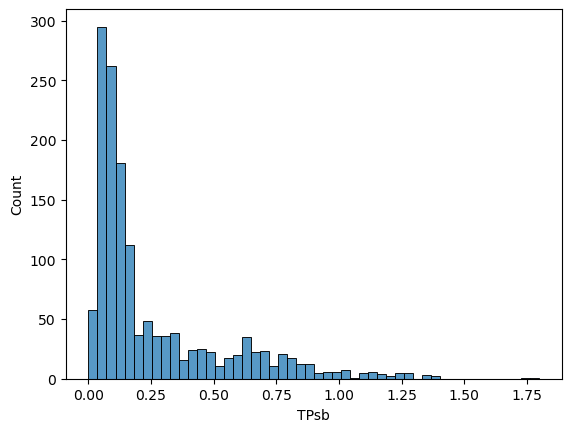

In [5]:
sns.histplot(data=delays_df, x="TPsb", bins=50)

In [6]:
delays_df[delays_df["TPsb"] > 2]

Empty DataFrame
Columns: [Network, Longitude, Latitude, TPsb]
Index: []

In [7]:
delays_df[delays_df["TPsb"] < 0]

Empty DataFrame
Columns: [Network, Longitude, Latitude, TPsb]
Index: []

Text(0.5, 1.0, 'max=1.80')

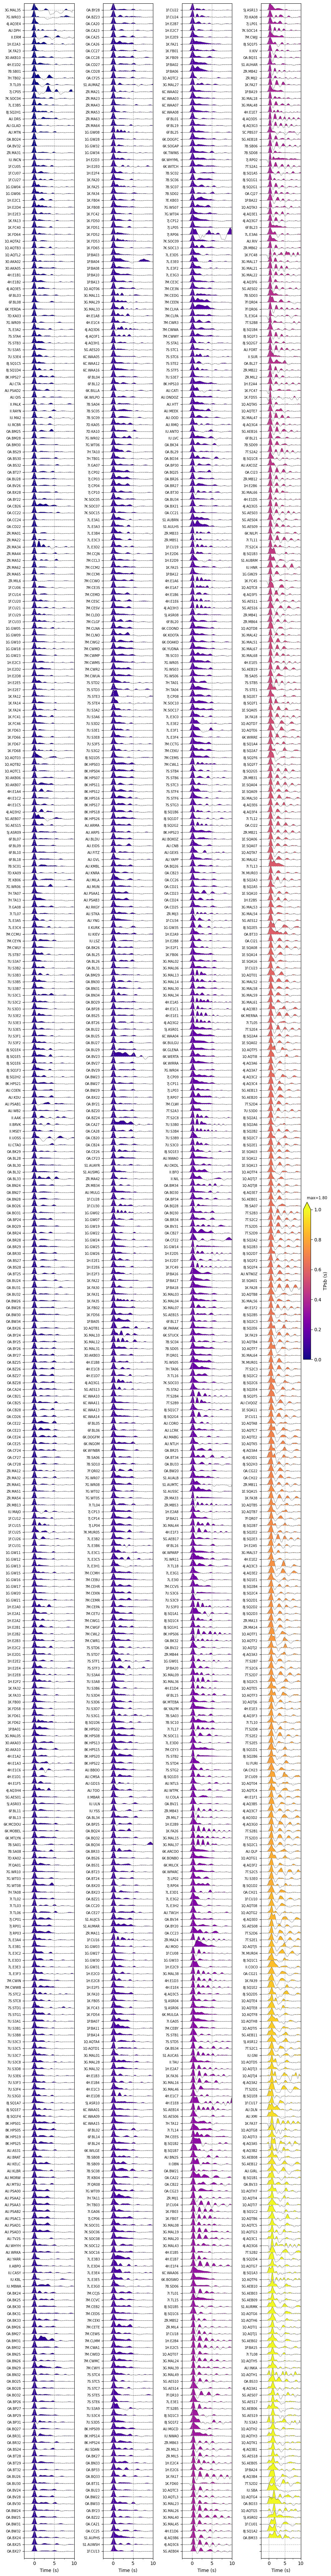

In [18]:
delays = [trace.stats.delay for trace in stacks]
norm = Normalize(vmin=0, vmax=1, clip=True)
cmap = cm.plasma
nstacks = len(stacks)
ncols = 4
stacks_per_column = ceil(nstacks / ncols)

stack_height = 0.2
column_height = stack_height * stacks_per_column
fig, axs = plt.subplots(1, ncols, figsize=(10, column_height + 2), tight_layout=True)
for j, ax in enumerate(axs):
    i = 0
    column_stations = []
    while i < stacks_per_column:
        try:
            stack = stacks[j * stacks_per_column + i]
        except IndexError:
            # plot nothing so that what is plotted doesn't get stretched along y
            ax.plot(times, data + i, alpha=0)
            i += 1
            continue
        times = stack.times() - stack.stats.onset.second
        data = stack.data
        data /= data.max()
        level = stacks_per_column - 1 - i
        ax.fill_between(times, data + level, level, where=data>=0, fc=cmap(norm(stack.stats.delay)))
        ax.plot(times, data + level, "k", lw=0.3)
        column_stations.append(".".join([stack.meta.network, stack.meta.station]))
        i += 1
    while i:
        try:
            ax.set_yticks(np.arange(stacks_per_column - 1, stacks_per_column - 1 - i, -1))
            ax.set_yticklabels(column_stations, fontsize="x-small", horizontalalignment="right")
        except ValueError:  # i != len(column_stations) 
            i -= 1
        else:
            break

for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(2.5))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlim([-2.5, 10])
    ax.set_ylim([-1, stacks_per_column])
    ax.grid(True, ls="--")
    ax.set_xlabel("Time (s)")

sm = cm.ScalarMappable(norm, cmap=cmap)
cbar = plt.colorbar(sm, label="TPsb (s)", ax=axs[-1], extend="max")
cbar.ax.set_title(f"max={max(delays):.2f}", fontsize="small", ha="left")
fig.savefig(os.path.join(run, "allstacks.pdf"))

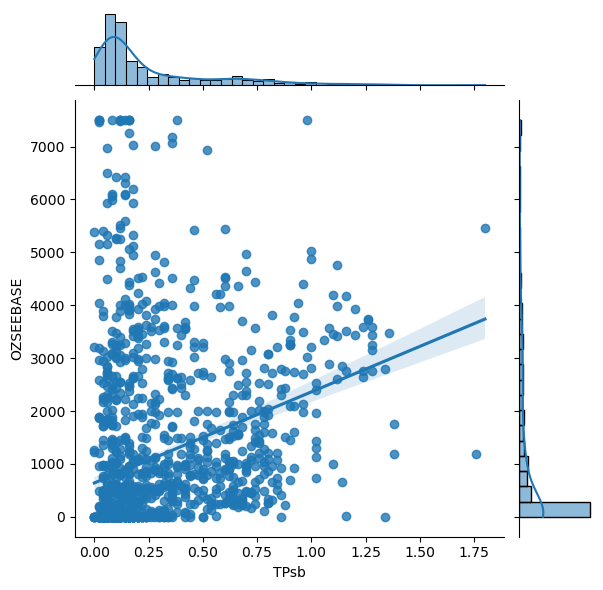

In [8]:
region = [112, 155, -46, -8]
grid = pygmt.xyz2grd(
    data=f"{os.environ['HOME']}/data//OZSEEBASE2021.xyz", region=region, spacing=0.01
)
grid *= -1
grid = pygmt.grdclip(grid=grid, above=(7500, 7500), below=(0, 0))
from xarray import DataArray

delays_df["OZSEEBASE"] = grid.sel(
    y=DataArray(delays_df["Latitude"].values, dims="z"),
    x=DataArray(delays_df["Longitude"].values, dims="z"),
    method="nearest",
)
g = sns.jointplot(delays_df, x="TPsb", y="OZSEEBASE", kind="reg")


In [25]:
events = {}
for tr in stream:
    m = tr.meta
    if m.event_id not in events:
        events[m.event_id.split("=")[-1]] = [m.event_longitude, m.event_latitude, m.event_depth, m.event_magnitude, m.distance]
events_df = pd.DataFrame(data=events, index=("Longitude", "Latitude", "Depth", "Magnitude", "Distance")).T
events_df.head()

Longitude  Latitude     Depth  Magnitude   Distance
603797971   128.4474    2.7153   56.1330       5.95  37.872504
603797981   145.1650   18.4629  531.0967       5.78  48.760136
603824898  -176.5188  -17.1613  370.1334       6.01  35.048825
603828422   126.1792    6.6020   48.5242       5.79  41.963573
603834082   149.1330   44.4691   34.0610       5.90  74.633609

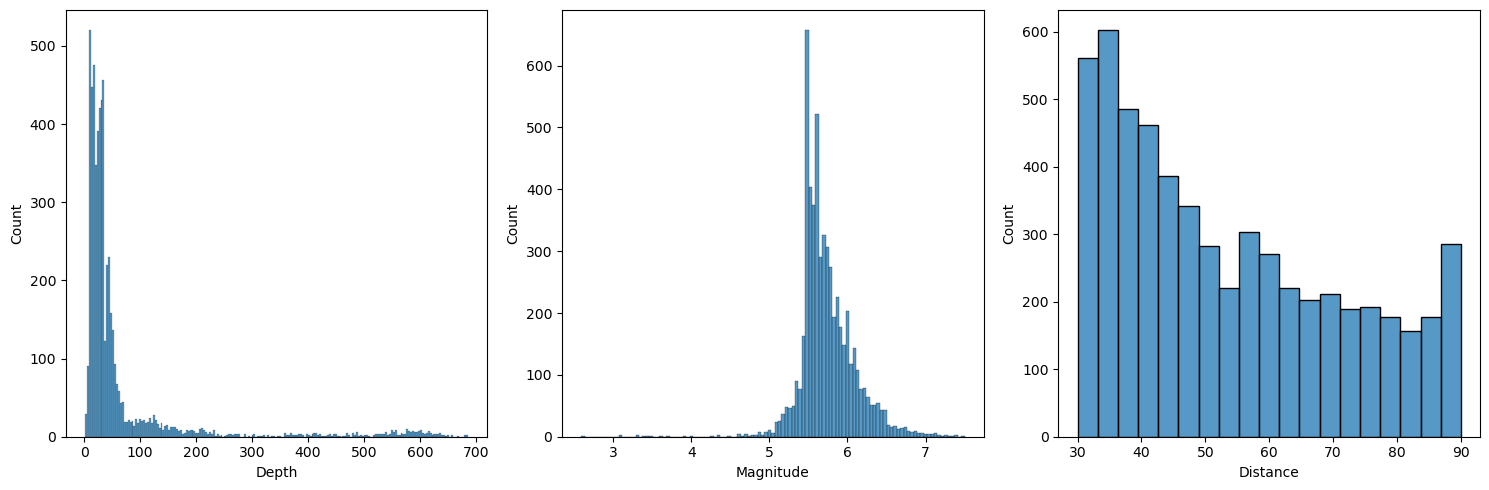

In [26]:
plot_these = ["Depth", "Magnitude", "Distance"]
fig, axs = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
for ax, d in zip(axs, plot_these):
    sns.histplot(data=events_df, x=d, ax=ax)
    ax.set_xlabel(d)

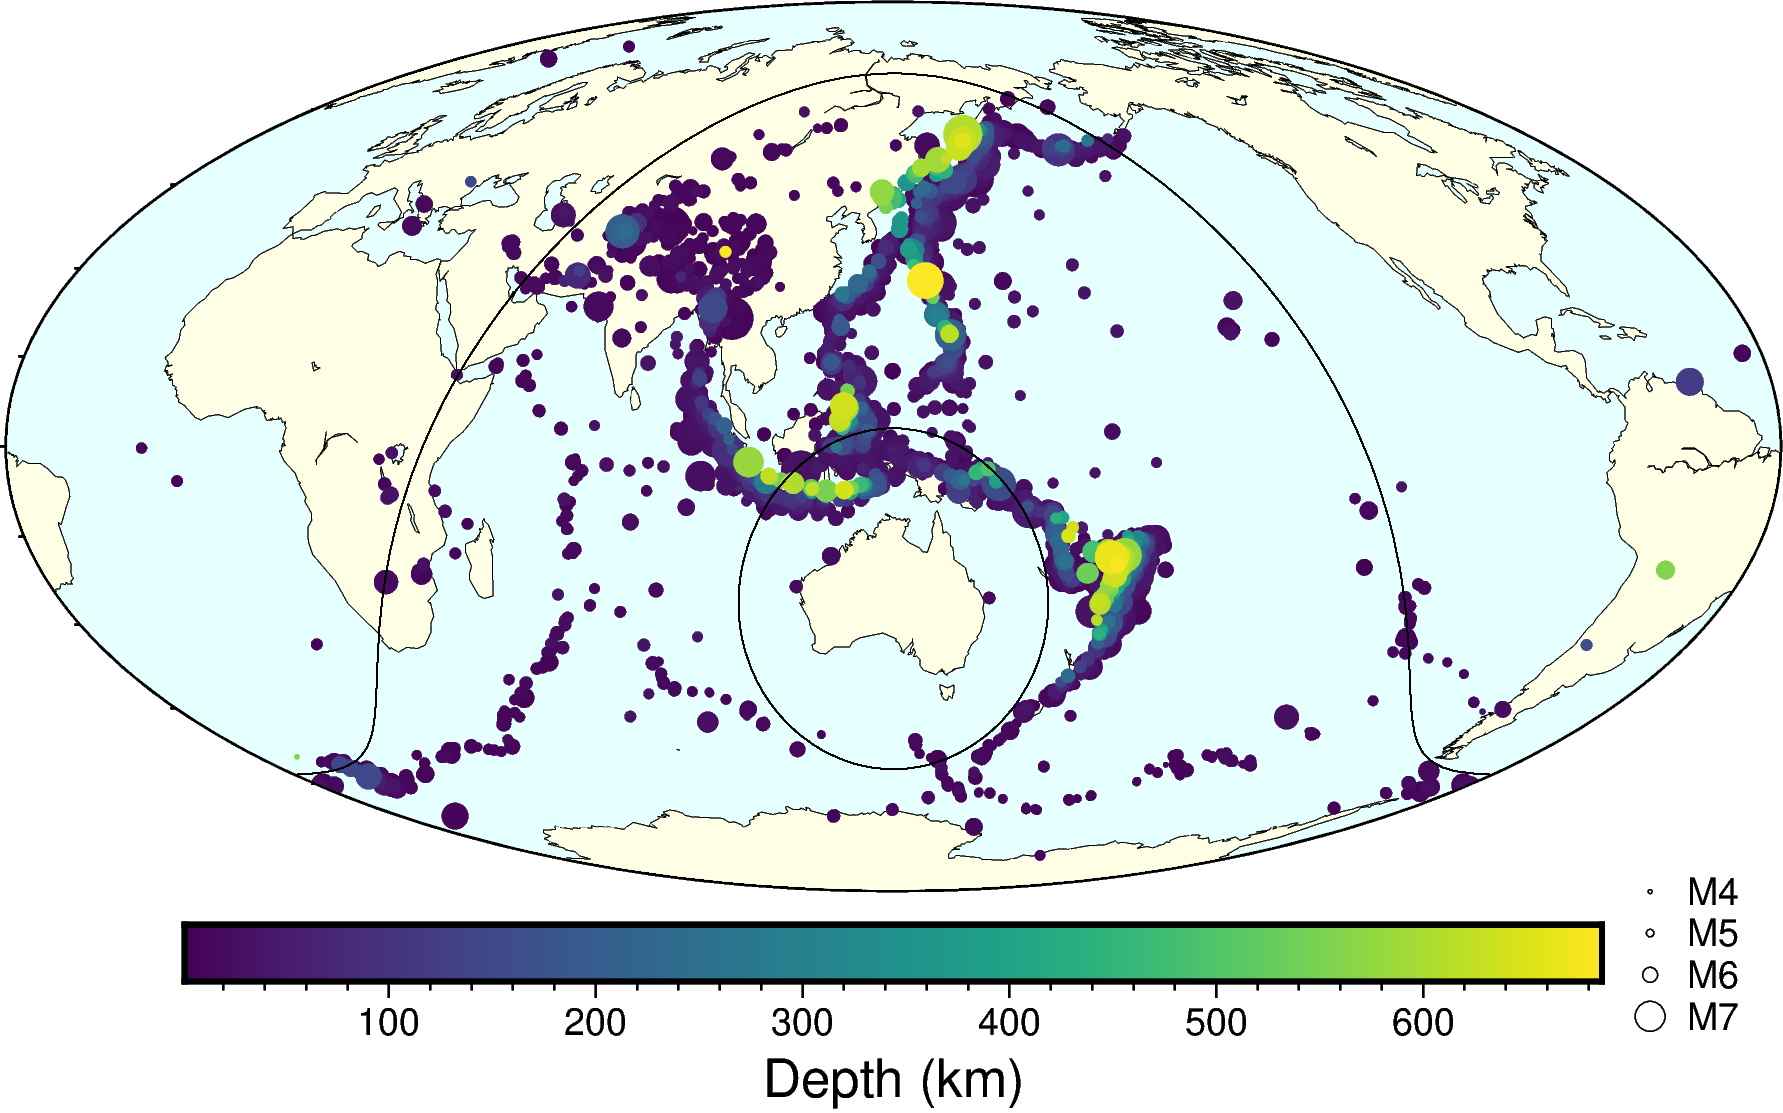

In [99]:
def magnitude_to_size(mag):
    return 0.002 * (2**mag)

events_df.sort_values(by=["Depth"], inplace=True)

lon = (112 + 155) / 2
lat = (-46 + -8) / 2

region = "d"
projection = f"W{lon}/15c"
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection, frame="f")
fig.coast(
    region=region,
    projection=projection,
    area_thresh=10000,
    shorelines="0.1,black,solid",
    land="#ffffe6",
    water="#e6ffff",
)
pygmt.makecpt(cmap="viridis", series=[events_df.Depth.min(), events_df.Depth.max()], background="o")
fig.plot(
    region=region,
    projection=projection,
    x=events_df.Longitude,
    y=events_df.Latitude,
    size=magnitude_to_size(events_df.Magnitude),
    style="cc",
    fill=events_df.Depth,
    cmap=True,
)
fig.colorbar(region=region, projection=projection, frame="af+lDepth (km)", position="JBC+o0/0.3")
fig.plot(
    region=region,
    projection=projection,
    x=[lon] * 2,
    y=[lat] * 2,
    size=[30 *2, 95*2],
    style="E-d",
)

# Create dummy points to get the magnitude legend
for mag in [4,5,6,7]:
    x, y = (0, 0)
    size = magnitude_to_size(mag)
    fig.plot(
        x=[x],
        y=[y],
        style="cc",
        size=[size],
        label=f"M{mag}+S{size}",
        transparency=100,  # set transparent
    )

fig.legend(position="JBR+jTR+o0.2/-0.3")
fig.show()
